# 나이브 베이스 분류기(Naive Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기
  * 베르누이 나이브 베이즈 분류기
  * 다항 나이브 베이즈 분류기

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델 가지고 만들어짐
* *N*개의 특성을 나타내는 벡터 **x**를 입력 받아 k개의 가능한 확률적 결과를 출력

\begin{equation}
p(C_k | x_1,...,x_n)
\end{equation}

* 위의 식에 베이즈 정리를 적용하면 다음과 같음

\begin{equation}
p(C_k | \textbf{x}) = \frac{p(C_k)p(\textbf{x}|C_k)}{p(\textbf{x})}
\end{equation}

* 위의 식에서 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음

\begin{equation}
\begin{split}
p(C_k | \textbf{x}) & \propto p(C_k)p(\textbf{x}|C_k) \\
& \propto p(C_k, x_1, ..., x_n)
\end{split}
\end{equation}

* 위의 식을 연쇄 법칙을 사용해 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & = p(C_k)p(x_1, ..., x_n | C_k) \\
& = p(C_k)p(x_1 | C_k)p(x_2, ..., x_n | C_k, x_1) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)p(x_3, ..., x_n | C_k, x_1, x_2) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)...p(x_n | C_k, x_1, x_2, ..., x_{n-1})
\end{split}
\end{equation}

* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{split}
\end{equation}

* 위의 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과

\begin{equation}
\hat{y} = \underset{k}{\arg\max} \; p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{equation}

In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.datasets import fetch_covtype,fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer

# 나이브베이즈의 핵심 작동원리
 * 각 클래스에 대한 가능도 (likelihood) 비교를 통한 분류
 * 즉 likelihood에 대한 이해가 가장 핵심적
 * 사실상 베이즈 정리의 철학을 기반으로 작동하는 분류기

# 베이즈 정리 
 * 새로운 정보를 토대로 어떤 사건이 발생했다는 주자엥 대한 신뢰도를 갱신해 나가는 방법
 * 사전지식을 이용한 분류 prior :기존에 알고있던 확률
 * likelihood : 특정 정보가 추가되는경우 : 키 정보만으로 성별을 구분할경우
 확률분포에서 정보에 대한 가능성
 * likelihood는 추가 정보이기 때문에 기존에 알고 있던 사전 지식(PRIOR)에 추가 정보(likelihood)를 얹어주는 방식으로 판단근거를 찾는 것이 더욱 바람직함
 * 즉 판단근거 = 사전지식 * 추가정보
 * 수식으로 쓰면 
  - 남자라고 판단할 근거 :p(성별 =남자) * P(키 =175 |성별 =남자)
  - 여자라고 판단할 근거 :p(성별 =여자) * P(키 =175 |성별 =여자)

 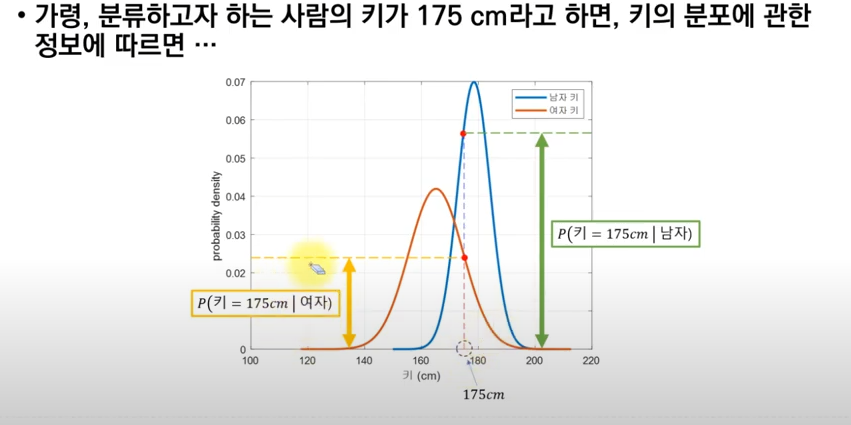
 

 * 가령 몸무게에 관한 정보가 추가된다면 사전정보에 추가 정보를 곱해주었던것 처럼 그 뒤에 계속 추가 정보를 덧 붙일수 있다. 
 * test data 사람의 몸무게가 80kg였다면 

  - 남자라고 판단할 근거 :p(성별 =남자) * P(키 =175 |성별 =남자) * p(몸무게 =80 |성별 =남자)
  - 여자라고 판단할 근거 :p(성별 =여자) * P(키 =175 |성별 =여자) * p(몸무게 =80 |성별 =여자)
  * 작동방식은 train 데이터에서 클래스별 비율을 계산하여 미리 사전확률을 계산함
  * 클래스별 feature의 분포를 추정한후 
  * prior 에 liklihood를 계속 곱해주어 가장 값이 큰 클로스로 분류됨

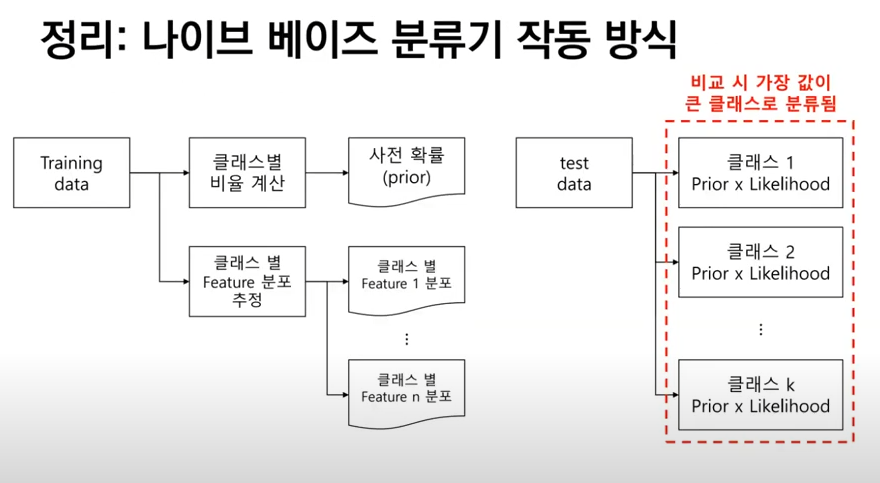

In [2]:
prior = [0.45,0.3,0.15,0.1]
likelihood = [[0.3,0.3,0.4],[0.7,0.2,0.1],[0.15,0.5,0.53],[0.6,0.02,0.2]]

#반복문을 돌면서 각각의 가능성 확률
idx = 0 
for c,xs in zip(prior,likelihood):
  result = 1 
  for x in xs:
    result *= x
  result *= c

  idx += 1
  print(f'{idx}번째 클래스의 가능성:{result}')

1번째 클래스의 가능성:0.0162
2번째 클래스의 가능성:0.0042
3번째 클래스의 가능성:0.0059625
4번째 클래스의 가능성:0.00024000000000000003


## 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/ml/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [3]:
covtype = fetch_covtype()

In [4]:
pd.DataFrame(covtype.data)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
covtype.target  

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

### 학습, 평가 데이터 분류

In [6]:
covtype_X = covtype.data
covtype_y = covtype.target

In [7]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X,covtype_y,test_size=0.2)

In [8]:
print('전체 데이터 크기 {}'.format(covtype_X.shape))
print('학습 데이터 크기 {}'.format(covtype_X_train.shape))
print('평가 데이터 크기 {}'.format(covtype_X_test.shape))

전체 데이터 크기 (581012, 54)
학습 데이터 크기 (464809, 54)
평가 데이터 크기 (116203, 54)


### 전처리

#### 전처리 전 데이터

In [9]:
covtype_df = pd.DataFrame(data=covtype_X_train)
covtype_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.096016,155.682597,14.116474,269.260817,46.409332,2349.245241,212.122627,223.300153,142.529349,1980.389661,...,0.044102,0.090196,0.077879,0.002786,0.003229,0.000211,0.000508,0.026833,0.023795,0.014856
std,280.178178,111.930093,7.489231,212.317977,58.192190,1560.661899,26.801760,19.781474,38.300800,1324.856328,...,0.205322,0.286463,0.267982,0.052710,0.056735,0.014519,0.022527,0.161594,0.152409,0.120975
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,261.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,599.000000,7116.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
covtype_test_df = pd.DataFrame(data=covtype_X_test)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2960.442433,155.553652,14.052623,270.097812,46.456950,2353.752072,212.239736,223.392967,142.523919,1979.897490,...,0.044465,0.091177,0.077063,0.002719,0.003356,0.000181,0.000534,0.026686,0.023631,0.015877
std,279.208229,111.848633,7.484099,213.471958,58.705823,1553.615514,26.641934,19.717418,38.169428,1321.553064,...,0.206127,0.287861,0.266693,0.052077,0.057836,0.013442,0.023093,0.161165,0.151897,0.125002
min,1871.000000,0.000000,0.000000,0.000000,-156.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2811.000000,58.000000,9.000000,108.000000,7.000000,1113.500000,198.000000,213.000000,119.000000,1025.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,2012.000000,218.000000,226.000000,143.000000,1712.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,260.000000,18.000000,390.000000,69.000000,3330.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3857.000000,360.000000,64.000000,1368.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7118.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 전처리 과정

In [11]:
 scaler = StandardScaler()
 covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
 covtype_X_test_scale = scaler.transform(covtype_X_test)

#### 전처리 후 데이터
* 평균은 0에 가깝게, 표준평차는 1에 가깝게 정규화

In [12]:
covtype_train_df = pd.DataFrame(data=covtype_X_train_scale)
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,...,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,6.893347e-16,-6.872238e-17,7.129295e-17,-1.392929e-16,3.395641e-16,-5.100968e-17,-5.229044e-16,-4.748082e-16,5.039135e-16,3.825108e-17,...,6.170147e-16,-3.823835e-15,2.753946e-15,2.997509e-15,-5.779860e-15,-6.462685e-15,-1.868842e-15,3.863337e-15,5.926864e-15,-4.633530e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.926420e+00,-1.390893e+00,-1.884905e+00,-1.268197e+00,-3.770430e+00,-1.505289e+00,-7.914512e+00,-1.128836e+01,-3.721319e+00,-1.494797e+00,...,-2.147946e-01,-3.148620e-01,-2.906144e-01,-5.285712e-02,-5.691876e-02,-1.452184e-02,-2.253871e-02,-1.660493e-01,-1.561240e-01,-1.227989e-01
25%,-5.357169e-01,-8.727117e-01,-6.831782e-01,-7.595258e-01,-6.772279e-01,-7.985372e-01,-5.269297e-01,-5.206975e-01,-6.143311e-01,-7.218826e-01,...,-2.147946e-01,-3.148620e-01,-2.906144e-01,-5.285712e-02,-5.691876e-02,-1.452184e-02,-2.253871e-02,-1.660493e-01,-1.561240e-01,-1.227989e-01
50%,1.317163e-01,-2.562548e-01,-1.490774e-01,-2.414344e-01,-2.819854e-01,-2.276250e-01,2.192908e-01,1.364837e-01,1.228830e-02,-2.040900e-01,...,-2.147946e-01,-3.148620e-01,-2.906144e-01,-5.285712e-02,-5.691876e-02,-1.452184e-02,-2.253871e-02,-1.660493e-01,-1.561240e-01,-1.227989e-01
75%,7.277662e-01,9.409223e-01,5.185486e-01,5.404126e-01,3.882083e-01,6.271415e-01,7.043341e-01,6.925602e-01,6.650169e-01,4.299417e-01,...,-2.147946e-01,-3.148620e-01,-2.906144e-01,-5.285712e-02,-5.691876e-02,-1.452184e-02,-2.253871e-02,-1.660493e-01,-1.561240e-01,-1.227989e-01
max,3.208333e+00,1.825404e+00,6.927758e+00,5.311563e+00,9.495970e+00,3.054319e+00,1.562488e+00,1.551951e+00,2.910403e+00,3.919380e+00,...,4.655611e+00,3.175995e+00,3.440986e+00,1.891893e+01,1.756890e+01,6.886181e+01,4.436812e+01,6.022309e+00,6.405164e+00,8.143393e+00


In [13]:
covtype_test_df = pd.DataFrame(data=covtype_X_test_scale)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,0.004806,-0.001152,-0.008526,0.003942,0.000818,0.002888,0.004369,0.004692,-0.000142,-0.000371,...,0.001769,0.003423,-0.003045,-0.001266,0.002237,-0.002075,0.001146,-0.000906,-0.001074,0.008447
std,0.996539,0.999273,0.999316,1.005436,1.008828,0.995486,0.994038,0.996763,0.996571,0.997508,...,1.003924,1.004883,0.995192,0.987992,1.019400,0.925835,1.025096,0.997346,0.996643,1.033288
min,-3.883590,-1.390893,-1.884905,-1.268197,-3.478294,-1.505289,-7.914512,-11.288360,-3.721319,-1.494797,...,-0.214795,-0.314862,-0.290614,-0.052857,-0.056919,-0.014522,-0.022539,-0.166049,-0.156124,-0.122799
25%,-0.528579,-0.872712,-0.683178,-0.759526,-0.677228,-0.791809,-0.526930,-0.520698,-0.614331,-0.721128,...,-0.214795,-0.314862,-0.290614,-0.052857,-0.056919,-0.014522,-0.022539,-0.166049,-0.156124,-0.122799
50%,0.131716,-0.256255,-0.149077,-0.241434,-0.299170,-0.216091,0.219291,0.136484,0.012288,-0.202580,...,-0.214795,-0.314862,-0.290614,-0.052857,-0.056919,-0.014522,-0.022539,-0.166049,-0.156124,-0.122799
75%,0.731335,0.931988,0.518549,0.568672,0.388208,0.628423,0.704334,0.692560,0.665017,0.429942,...,-0.214795,-0.314862,-0.290614,-0.052857,-0.056919,-0.014522,-0.022539,-0.166049,-0.156124,-0.122799
max,3.204764,1.825404,6.660708,5.174976,9.530338,3.054960,1.562488,1.551951,2.910403,3.877866,...,4.655611,3.175995,3.440986,18.918929,17.568899,68.861811,44.368115,6.022309,6.405164,8.143393


## 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [14]:
 newsgroup = fetch_20newsgroups()

In [ ]:
 print(newsgroup.DESCR)

In [16]:
 #나이브 베이즈를 위한 테디터
 newsgroup.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 학습, 평가 데이터 분류

In [17]:
#위 다운로드 받은 데이터를 아래처럼 바로 분리 가능함
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [18]:
X_train,y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer
* 문서에 나온 단어의 수를 세서 벡터 생성

In [19]:
count_vectorizer = CountVectorizer()

In [20]:
 X_train_count = count_vectorizer.fit_transform(X_train)
 X_test_count = count_vectorizer.transform(X_test)

데이터를 희소 행렬 형태로 표현

In [21]:
 X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [22]:
for v in X_train_count[0]:
  print(v)

  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (0, 37565)	1
  (0, 113986)	1
  (0, 83256)	1
  (0, 86001)	1
  (0, 51730)	1
  (0, 109271)	1
  (0, 128026)	1
  (0, 96144)	1
  (0, 78784)	1
  (0, 63363)	1
  (0, 90252)	1
  (0, 123989)	1
  (0, 67156)	1
  (0, 128402)	2
  (0, 62221)	1
  (0, 57308)	1
  (0, 76722)	1
  (0, 94362)	1
  (0, 78955)	1
  (0, 114428)	1
  (0, 66098)	1
  (0, 35187)	1
  (0, 35983)	1
  (0, 128420)	1
  (0, 86580)	1


#### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [23]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [24]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [25]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [26]:
 print(X_train_hash)

  (0, 80)	-0.0642824346533225
  (0, 108)	0.0642824346533225
  (0, 111)	-0.128564869306645
  (0, 145)	0.0642824346533225
  (0, 158)	0.0642824346533225
  (0, 159)	-0.0642824346533225
  (0, 161)	0.0642824346533225
  (0, 165)	-0.0642824346533225
  (0, 171)	0.0642824346533225
  (0, 182)	0.0642824346533225
  (0, 195)	-0.0642824346533225
  (0, 196)	0.19284730395996752
  (0, 205)	-0.0642824346533225
  (0, 209)	0.0642824346533225
  (0, 234)	0.0642824346533225
  (0, 237)	0.0642824346533225
  (0, 248)	0.0642824346533225
  (0, 265)	0.19284730395996752
  (0, 274)	0.0642824346533225
  (0, 277)	0.19284730395996752
  (0, 284)	-0.0642824346533225
  (0, 286)	-0.0642824346533225
  (0, 296)	0.0642824346533225
  (0, 362)	-0.0642824346533225
  (0, 364)	-0.0642824346533225
  :	:
  (11313, 620)	0.09622504486493763
  (11313, 622)	-0.19245008972987526
  (11313, 636)	-0.09622504486493763
  (11313, 640)	-0.09622504486493763
  (11313, 682)	0.09622504486493763
  (11313, 697)	-0.19245008972987526
  (11313, 710)	-0.0

#### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [27]:
 tfidf_vectorizer = TfidfVectorizer()

In [28]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
 X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [30]:
 for v in X_train_tfidf[0]:
   print(v)

  (0, 86580)	0.13157118714240987
  (0, 128420)	0.04278499079283093
  (0, 35983)	0.03770448563619875
  (0, 35187)	0.09353930598317124
  (0, 66098)	0.09785515708314481
  (0, 114428)	0.05511105154696676
  (0, 78955)	0.05989856888061599
  (0, 94362)	0.055457031390147224
  (0, 76722)	0.06908779999621749
  (0, 57308)	0.1558717009157704
  (0, 62221)	0.02921527992427867
  (0, 128402)	0.05922294083277842
  (0, 67156)	0.07313443922740179
  (0, 123989)	0.08207027465330353
  (0, 90252)	0.031889368795417566
  (0, 63363)	0.08342748387969037
  (0, 78784)	0.0633940918806495
  (0, 96144)	0.10826904490745741
  (0, 128026)	0.060622095889758885
  (0, 109271)	0.10844724822064673
  (0, 51730)	0.09714744057976722
  (0, 86001)	0.07000411445838192
  (0, 83256)	0.08844382496462173
  (0, 113986)	0.17691750674853082
  (0, 37565)	0.03431760442478462
  :	:
  (0, 4605)	0.06332603952480323
  (0, 76032)	0.019219463052223086
  (0, 92081)	0.09913274493911223
  (0, 40998)	0.0780136819691811
  (0, 79666)	0.109364012524142

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [31]:
model = GaussianNB()
model.fit(covtype_X_train_scale,covtype_y_train)

GaussianNB()

In [32]:
predict = model.predict(covtype_X_train_scale)
acc = metrics.accuracy_score(covtype_y_train,predict)
f1 = metrics.f1_score(covtype_y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.08759296829450376
Train F1:[0.0403603  0.01802919 0.33497053 0.13729431 0.04295275 0.07088548
 0.23351323]


In [33]:
#test데이터에 대한 정확도와 f1score 
predict = model.predict(covtype_X_test_scale)
acc = metrics.accuracy_score(covtype_y_test,predict)
f1 = metrics.f1_score(covtype_y_test,predict,average=None)

print('test Accuracy:{}'.format(acc))
print('test F1:{}'.format(f1))

test Accuracy:0.08867240949028855
test F1:[0.0407327  0.01763773 0.3350565  0.14260295 0.04296303 0.06998591
 0.24029722]


In [34]:
#시각화
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [35]:
def make_meshgrid(x,y,h=.02):
  x_min,x_max = x.min()-1, x.max()+1
  y_min,y_max = y.min()-1, y.max()+1
  xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
  return xx,yy

def plot_contours(clf,xx,yy,**params):
  Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx,yy,Z,**params)

  return out

In [36]:
X,y = make_blobs(n_samples=1000)

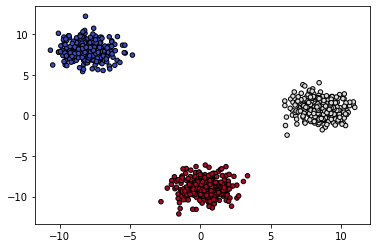

In [37]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [38]:
#이 상태에서 가우시안
model = GaussianNB()
model.fit(X,y)

GaussianNB()

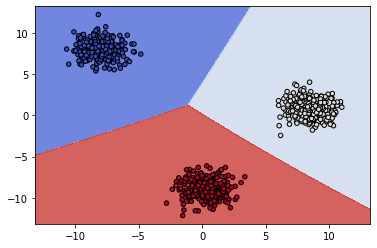

In [39]:
xx,yy = make_meshgrid(X[:,],X[:,1])
plot_contours(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [41]:
model = BernoulliNB()
model.fit(X_train_count,y_train)

BernoulliNB()

In [43]:
predict = model.predict(X_train_count)
acc =metrics.accuracy_score(y_train,predict)
f1 = metrics.f1_score(y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.7821283365741559
Train F1:[0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [44]:
predict = model.predict(X_test_count)
acc =metrics.accuracy_score(y_test,predict)
f1 = metrics.f1_score(y_test,predict,average=None)

print('Test Accuracy:{}'.format(acc))
print('Test F1:{}'.format(f1))

Test Accuracy:0.6307753584705258
Test F1:[0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 학습 및 평가 (Hash)

In [45]:
model = BernoulliNB()
model.fit(X_train_hash,y_train)

BernoulliNB()

In [46]:
predict = model.predict(X_train_hash)
acc =metrics.accuracy_score(y_train,predict)
f1 = metrics.f1_score(y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.5951917977726711
Train F1:[0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [47]:
predict = model.predict(X_test_hash)
acc =metrics.accuracy_score(y_test,predict)
f1 = metrics.f1_score(y_test,predict,average=None)

print('Test Accuracy:{}'.format(acc))
print('Test F1:{}'.format(f1))

Test Accuracy:0.4430430164630908
Test F1:[0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


### 학습 및 평가 (Tf-idf)

In [48]:
model = BernoulliNB()
model.fit(X_train_tfidf,y_train)

BernoulliNB()

In [49]:
predict = model.predict(X_train_tfidf)
acc =metrics.accuracy_score(y_train,predict)
f1 = metrics.f1_score(y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.7821283365741559
Train F1:[0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [50]:
predict = model.predict(X_test_tfidf)
acc =metrics.accuracy_score(y_test,predict)
f1 = metrics.f1_score(y_test,predict,average=None)

print('Test Accuracy:{}'.format(acc))
print('Test F1:{}'.format(f1))

Test Accuracy:0.6307753584705258
Test F1:[0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 시각화

In [68]:
X,y = make_blobs(n_samples=1000)

In [69]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

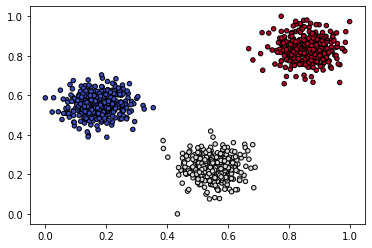

In [70]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [71]:
model = BernoulliNB()
model.fit(X,y)

BernoulliNB()

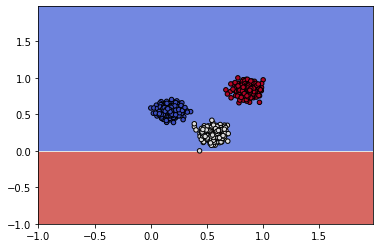

In [72]:
xx,yy = make_meshgrid(X[:,],X[:,1])
plot_contours(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [73]:
model = MultinomialNB()
model.fit(X_train_count,y_train)

MultinomialNB()

In [74]:
predict = model.predict(X_train_count)
acc =metrics.accuracy_score(y_train,predict)
f1 = metrics.f1_score(y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.9245182959165635
Train F1:[0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [75]:
predict = model.predict(X_test_count)
acc =metrics.accuracy_score(y_test,predict)
f1 = metrics.f1_score(y_test,predict,average=None)

print('Test Accuracy:{}'.format(acc))
print('Test F1:{}'.format(f1))

Test Accuracy:0.7728359001593202
Test F1:[0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### 학습 및 평가 (Tf-idf)

In [76]:
model = MultinomialNB()
model.fit(X_train_tfidf,y_train)

MultinomialNB()

In [77]:
predict = model.predict(X_train_tfidf)
acc =metrics.accuracy_score(y_train,predict)
f1 = metrics.f1_score(y_train,predict,average=None)

print('Train Accuracy:{}'.format(acc))
print('Train F1:{}'.format(f1))

Train Accuracy:0.9326498143892522
Train F1:[0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [78]:
predict = model.predict(X_test_tfidf)
acc =metrics.accuracy_score(y_test,predict)
f1 = metrics.f1_score(y_test,predict,average=None)

print('Test Accuracy:{}'.format(acc))
print('Test F1:{}'.format(f1))

Test Accuracy:0.7738980350504514
Test F1:[0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


### 시각화

In [80]:
X,y = make_blobs(n_samples=1000)

In [81]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

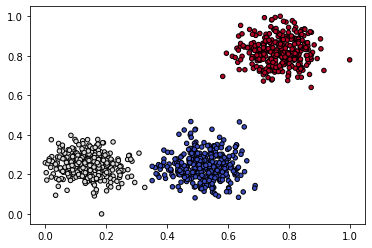

In [82]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [83]:
model = MultinomialNB()
model.fit(X,y)

MultinomialNB()

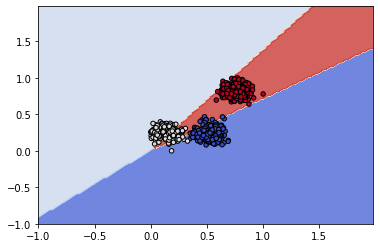

In [84]:
xx,yy = make_meshgrid(X[:,],X[:,1])
plot_contours(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')